## Import Modules

In [1]:
# Import all the required modules
import math
from collections import OrderedDict
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install torch-lr-finder
from torch_lr_finder import LRFinder

if 'google.colab' in sys.modules:
    # Download the repo from GitHub
    print("Downloading repository on Colab...")
    !git clone -b kernel_viz https://github.com/Shilpaj1994/ERA.git

    # Import files from the downloaded repository
    sys.path.insert(0,'./ERA/Session10/')

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Cloning into 'ERA'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 299 (delta 116), reused 249 (delta 66), pack-reused 0
Receiving objects: 100% (299/299), 29.91 MiB | 25.67 MiB/s, done.
Resolving deltas: 100% (116/116), done.


## Dataset Analysis

## Extract and Load the Data

In [2]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 49068062.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Data Statistics

[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


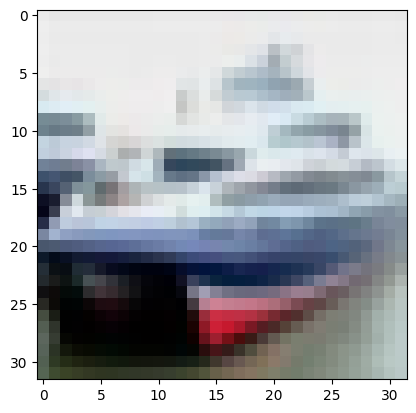

In [3]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

## Visualize Training Data

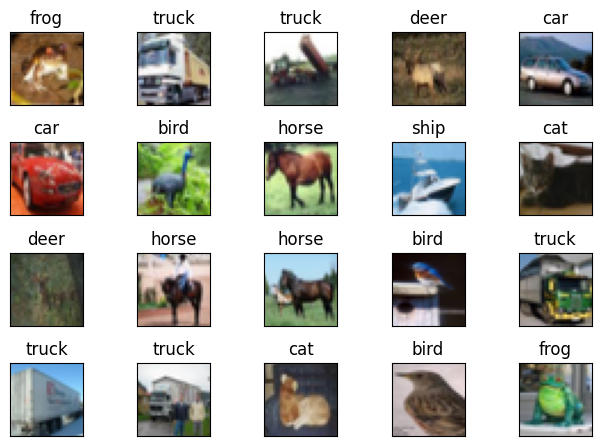

In [4]:
from visualize import display_cifar_data_samples

DISPLAY_SAMPLES = 20
sample, _ = train[4]
display_cifar_data_samples(train, DISPLAY_SAMPLES, classes)


## Transformations

In [5]:
# Train Phase transformations
train_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=0.2),
    'horizontalflip': A.HorizontalFlip(),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968*255, 0.48215827*255 ,0.44653124*255], mask_fill_value=None),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

# Test Phase transformations
test_set_transforms = {
    'normalize': A.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2()
}

train_transforms = A.Compose(train_set_transforms.values())
test_transforms = A.Compose(test_set_transforms.values())

In [6]:
from datasets import AlbumDataset

train_set = AlbumDataset('./data', train=True, download=True, transform=train_transforms)
test_set = AlbumDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


## Visualize Augmentations

Files already downloaded and verified


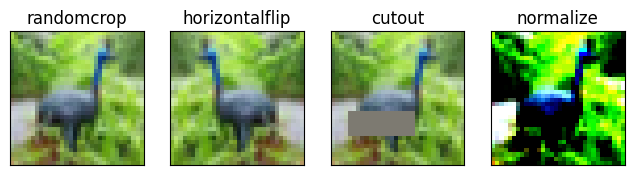

In [7]:
from visualize import visualize_cifar_augmentation

aug_train = AlbumDataset('./data', train=True, download=True)

aug_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=1),
    'horizontalflip': A.HorizontalFlip(p=1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=(0.49139968*255, 0.48215827*255, 0.44653124*255), mask_fill_value=None, p=1),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

visualize_cifar_augmentation(aug_train, aug_set_transforms)

## Dataloader Arguments & Test/Train Dataloaders

In [8]:
SEED = 8
BATCH_SIZE = 512

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


## Model and its Parameters

In [9]:
from custom_resnet import Session10Net
from utils import get_summary

get_summary(Session10Net(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## One Cycle Policy

In [10]:
# Put the model on selected device
model = Session10Net().to(device)

# Optimization algorithm to update the weights
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Loss Function
criterion = nn.CrossEntropyLoss()

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.54E-02


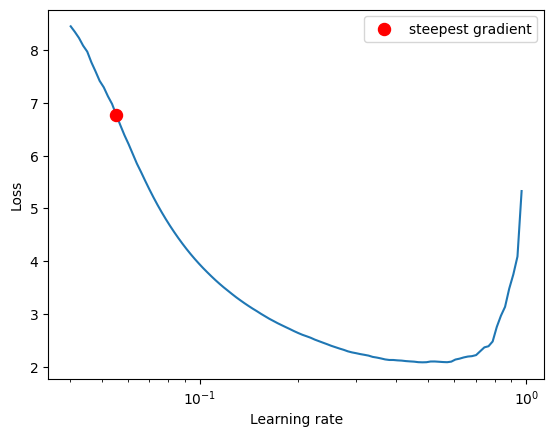

In [11]:
# LR finder
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

## Parameters

In [12]:
EPOCHS = 24

MAX_LR = 5.54E-02    # Suggested LR
STEPS_PER_EPOCH = len(train_loader)

## Model Training and Testing

In [13]:
from training_utils import train, test, get_lr

In [14]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=MAX_LR,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                epochs=EPOCHS,
                                                pct_start=5/EPOCHS,
                                                div_factor=100,
                                                three_phase=False,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                )

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    learning_rates.append(get_lr(optimizer))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.1853 Batch_id=97 Accuracy=51.26: 100%|██████████| 98/98 [00:18<00:00,  5.23it/s]


Test set: Average loss: 0.0028, Accuracy: 5462/10000 (54.62%)

Epoch 2


Train: Loss=0.8920 Batch_id=97 Accuracy=67.50: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]


Test set: Average loss: 0.0024, Accuracy: 6509/10000 (65.09%)

Epoch 3


Train: Loss=0.7929 Batch_id=97 Accuracy=72.98: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]


Test set: Average loss: 0.0032, Accuracy: 5733/10000 (57.33%)

Epoch 4


Train: Loss=0.6705 Batch_id=97 Accuracy=76.81: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]


Test set: Average loss: 0.0031, Accuracy: 5689/10000 (56.89%)

Epoch 5


Train: Loss=0.7349 Batch_id=97 Accuracy=76.71: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]


Test set: Average loss: 0.0020, Accuracy: 6558/10000 (65.58%)

Epoch 6


Train: Loss=0.6518 Batch_id=97 Accuracy=76.65: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]


Test set: Average loss: 0.0021, Accuracy: 6564/10000 (65.64%)

Epoch 7


Train: Loss=0.7403 Batch_id=97 Accuracy=77.61: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]


Test set: Average loss: 0.0016, Accuracy: 7120/10000 (71.20%)

Epoch 8


Train: Loss=0.6873 Batch_id=97 Accuracy=77.77: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]


Test set: Average loss: 0.0018, Accuracy: 6922/10000 (69.22%)

Epoch 9


Train: Loss=0.6865 Batch_id=97 Accuracy=78.74: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]


Test set: Average loss: 0.0018, Accuracy: 7079/10000 (70.79%)

Epoch 10


Train: Loss=0.7983 Batch_id=97 Accuracy=78.88: 100%|██████████| 98/98 [00:19<00:00,  5.14it/s]


Test set: Average loss: 0.0019, Accuracy: 7006/10000 (70.06%)

Epoch 11


Train: Loss=0.5931 Batch_id=97 Accuracy=79.20: 100%|██████████| 98/98 [00:19<00:00,  5.13it/s]


Test set: Average loss: 0.0016, Accuracy: 7335/10000 (73.35%)

Epoch 12


Train: Loss=0.5528 Batch_id=97 Accuracy=79.63: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]


Test set: Average loss: 0.0014, Accuracy: 7731/10000 (77.31%)

Epoch 13


Train: Loss=0.5943 Batch_id=97 Accuracy=80.60: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]


Test set: Average loss: 0.0015, Accuracy: 7397/10000 (73.97%)

Epoch 14


Train: Loss=0.5775 Batch_id=97 Accuracy=80.66: 100%|██████████| 98/98 [00:19<00:00,  5.13it/s]


Test set: Average loss: 0.0013, Accuracy: 7651/10000 (76.51%)

Epoch 15


Train: Loss=0.5291 Batch_id=97 Accuracy=81.57: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]


Test set: Average loss: 0.0013, Accuracy: 7796/10000 (77.96%)

Epoch 16


Train: Loss=0.4655 Batch_id=97 Accuracy=82.77: 100%|██████████| 98/98 [00:19<00:00,  5.14it/s]


Test set: Average loss: 0.0013, Accuracy: 7819/10000 (78.19%)

Epoch 17


Train: Loss=0.4880 Batch_id=97 Accuracy=82.85: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]


Test set: Average loss: 0.0012, Accuracy: 7973/10000 (79.73%)

Epoch 18


Train: Loss=0.4666 Batch_id=97 Accuracy=84.00: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]


Test set: Average loss: 0.0011, Accuracy: 8155/10000 (81.55%)

Epoch 19


Train: Loss=0.4284 Batch_id=97 Accuracy=85.32: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]


Test set: Average loss: 0.0012, Accuracy: 7948/10000 (79.48%)

Epoch 20


Train: Loss=0.3438 Batch_id=97 Accuracy=86.30: 100%|██████████| 98/98 [00:18<00:00,  5.18it/s]


Test set: Average loss: 0.0011, Accuracy: 8171/10000 (81.71%)

Epoch 21


Train: Loss=0.3512 Batch_id=97 Accuracy=87.98: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]


Test set: Average loss: 0.0010, Accuracy: 8369/10000 (83.69%)

Epoch 22


Train: Loss=0.2991 Batch_id=97 Accuracy=89.78: 100%|██████████| 98/98 [00:18<00:00,  5.16it/s]


Test set: Average loss: 0.0008, Accuracy: 8671/10000 (86.71%)

Epoch 23


Train: Loss=0.2060 Batch_id=97 Accuracy=92.01: 100%|██████████| 98/98 [00:18<00:00,  5.20it/s]


Test set: Average loss: 0.0007, Accuracy: 8874/10000 (88.74%)

Epoch 24


Train: Loss=0.1469 Batch_id=97 Accuracy=94.65: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]


Test set: Average loss: 0.0006, Accuracy: 8969/10000 (89.69%)



## Visualize Train and Test - Loss and Accuracies

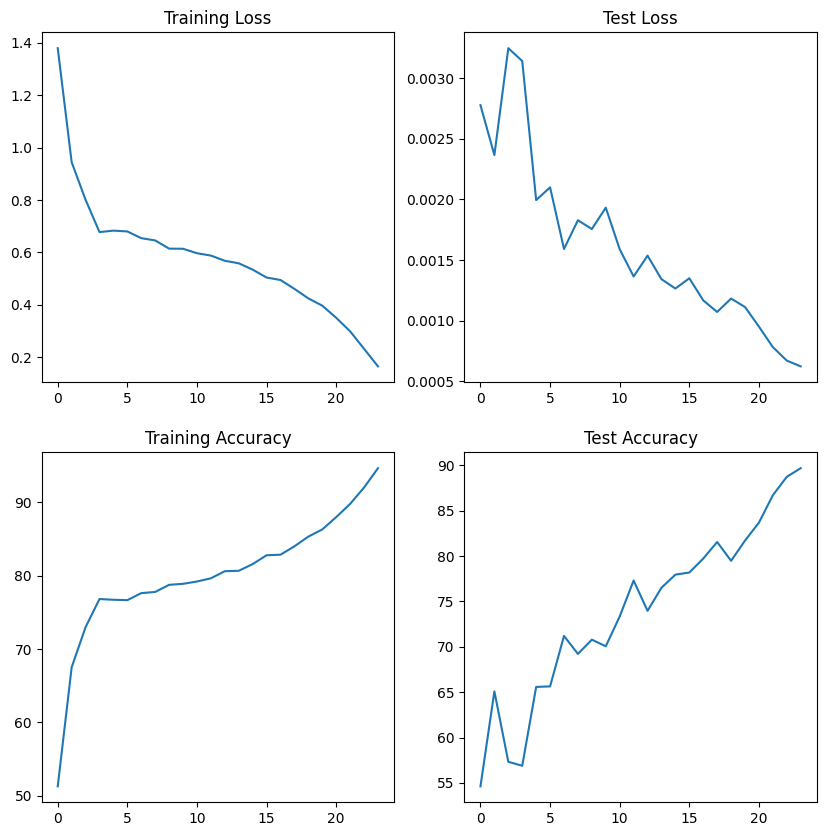

In [15]:
# Print loss and accuracy
from visualize import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

---

## Visualize the One Cycle Policy Implementation

Text(0.5, 1.0, 'Training Learning Rate')

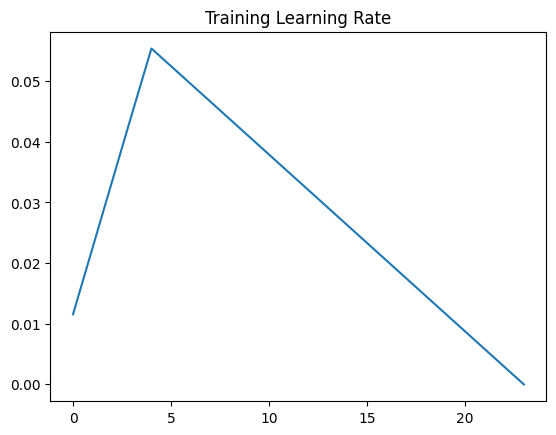

In [16]:
import matplotlib.pyplot as plt

plt.plot(learning_rates)
plt.title("Training Learning Rate")

---

## Visualize Misclassified Images

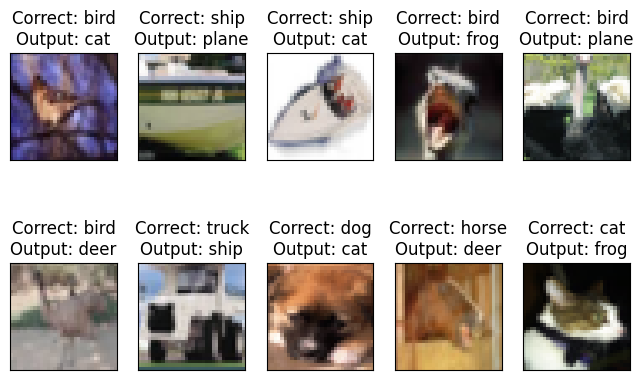

In [17]:
from utils import get_misclassified_data
from visualize import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.4942/0.2466, -0.4851/0.2428, -0.4504/0.2615],
    std=[1/0.2466, 1/0.2428, 1/0.2615]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=10)

---

## Feature Map Visualization

Feature Maps of kernel number 32 for all 6 convolution layers: 
Kernels from Layer 2: 


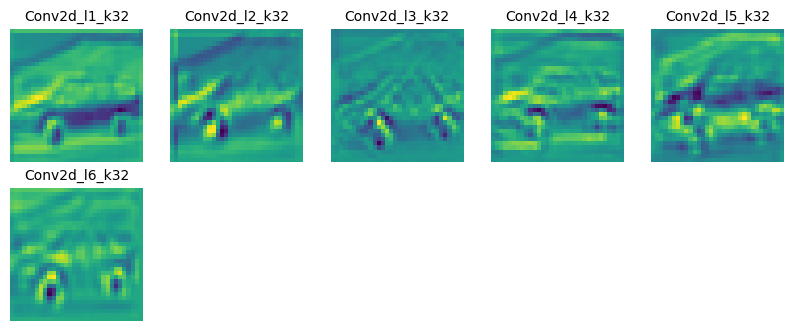

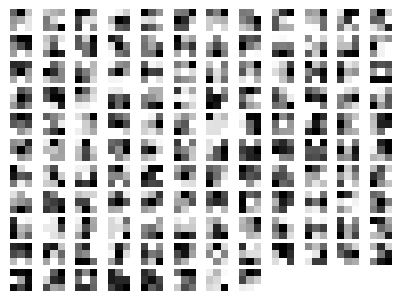

In [31]:
from visualize import FeatureMapVisualizer

# Create an object of the Class
model = model.to('cpu')
viz = FeatureMapVisualizer(model)

# Get a sample Image
image, _ = train_set[4]

# Visualize feature maps for kernel number 32
print("Feature Maps of kernel number 32 for all 6 convolution layers: ")
viz.visualize_feature_map_of_kernel(image=image, kernel_number=32)

# Visualize kernels from layer 2
print("Kernels from Layer 2: ")
viz.visualize_kernels_from_layer(layer_number=2)

---

## Confusion Matrix

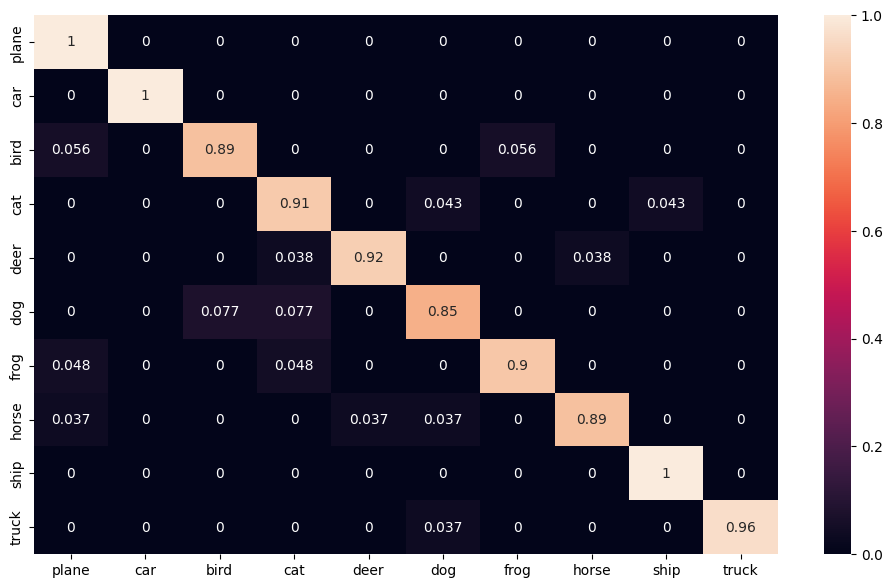

In [29]:
from visualize import visualize_confusion_matrix

visualize_confusion_matrix(classes, device, model, test_loader)

---

## Save/Load Model

In [32]:
# Save Model
torch.save(model, './model.pth')

In [ ]:
# # Load Model
# model = Session10Net()
# # # model.load_state_dict(torch.load('./model.pth'))
# # # torch.load('./model.pth', map_location=torch.device('cpu'))
# torch.load('./data/model_2.pth', map_location=torch.device('cuda'))
# model.eval()